# Registration Notebook

In [1]:
from organoid import preprocessing
from organoid import reconstruction
import numpy as np
import tifffile
from pathlib import Path
from glob import glob

c:\Users\gros\Anaconda3\envs\organoid-env\lib\site-packages\IO\IO.py:26: UserWarning: KLB library is not installed
  warnings.warn("KLB library is not installed")


pyklb library not found, klb files will not be generated


In [ ]:
folder = r'Z:\EqpLenne2\SHARED\Wave_project\2nd_Big_Wave\Big_experiment_wave\Hoechst_FoxA2_Oct4_Bra\72_5h\Hoechts_FoxA2_Oct4_Bra_72_5h_big_bottom\tifs\filt'
im=tifffile.imread(rf'{folder}\5_filt.tif')
print(im.min(),im.max(),im.mean())

In [ ]:
folder_data_in = rf"C:\Users\gros\Desktop\DATA\Valentin\Dapi_Ecad_Bra_Sox2_72_5h_re_big_bottom\notnorm"
folder_data_out = rf'C:\Users\gros\Desktop\DATA\Valentin\Dapi_Ecad_Bra_Sox2_72_5h_re_big_bottom'
samples = []
paths = sorted(glob(rf'{folder_data_in}/*.tif'))

for path in paths :
    samples.append(Path(path).stem)

for sample in samples:
    image = tifffile.imread(rf'{folder_data_in}/{sample}.tif',dtype=np.float16)
    print(image.shape)
    new_image=np.zeros_like(image,dtype=np.float16)    
    new_image = (image-image.min())/(image.max()-image.min())*10000
    tifffile.imwrite(rf'{folder_data_out}/{sample}.tif', new_image)


If necessary, you can plot here the positions of all samples (from the metadata), to match the two sides

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] [1, 2, 4, 3, 5, 6, 7, 8, 9, 10, 11]


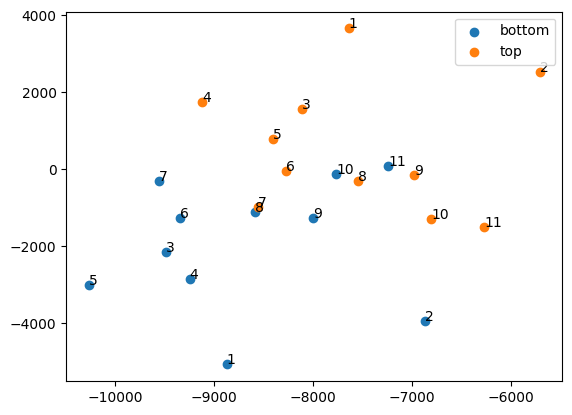

In [20]:
path = rf'Z:\EqpLenne2\SHARED\Wave_project\2nd_Big_Wave\Big_experiment_wave\Hoechst_FoxA2_Oct4_Bra\72_5h'
path_bottom_positions=rf'{path}\multipoints_bottom.xml'
path_top_positions=rf'{path}\multipoints_top.xml'


reconstruction.plot_positions(path_bottom_positions=path_bottom_positions,path_top_positions=path_top_positions)
list_bottom,list_top=reconstruction.associate_top_bottom(
      path_bottom_positions=path_bottom_positions,
    path_top_positions=path_top_positions
)
print(list_bottom,list_top)

Give the path to your data and name of images

In [21]:
#if you did not use the function associate_top_bottom, you can define the list_ref and list_float manually,
#for example if you have one sample and 2 views : list_ref=['view1'] and list_float=['view2']
#or with 2 samples and 2 views : list_ref=['01','02'] and list_float=['03','04'] with the right names of your images.

#Below we generate automatically the list_ref and list_float from the number paired above, bottom with top
#You can tune the names below : if the samples are named 01_view1, 01_view2, 02_view1, 02_view2, then
#list_ref = ["{:02d}_view1.format(i) for i in list_bottom]
#list_float = ["{:02d}_view2.format(i) for i in list_bottom]

# list_ref = ["{:02d}_filt_b".format(i) for i in list_bottom]
# list_float = ["{:02d}_filt_t".format(i) for i in list_top]
list_ref=['4_bottom','5_bottom']
list_float=['3_top','5_top']
print(list_ref)
print(list_float)
channels = [
"dapi",
'foxa2',
'oct4',
'bra'
]  # example of channels. If you have only one channel, just put one element in the list


['4_bottom', '5_bottom']
['3_top', '5_top']


Create the folder structure necessary for the registration. All files, reference and float, need to be in the same folder, folder_experiment.

In [25]:
reconstruction.create_folders(
    folder_experiment= rf'C:\Users\gros\Desktop\DATA\Valentin\Hoechst_FoxA2_Oct4_Bra_78h\small',
    list_ref=list_ref, list_float=list_float, channels=channels
)

Register automatically

To register your floating image onto the reference one, you should have an idea of the transformation to apply.  From this approximative initial transformation, the algorithm will find the exact transformation to match the 2 sides.

If your image has multiple channels, one will be the reference one, registered first. The second part of the code executes the registration for the other channels, using the same transformation as computed for the reference.

In [43]:
# from now on, we consider only one sample. If you have multiple samples, you can loop : list_ref[i]
path= rf'C:\Users\gros\Desktop\DATA\Valentin\Hoechst_FoxA2_Oct4_Bra_78h\small'
for i in [1] :
    filename_ref = list_ref[i]
    filename_float = list_float[i]
    input_voxel = [0.6,0.6,1]
    output_voxel = [0.6,0.6,1]
    channel_reference = "dapi"

    # rot=[0,0,180]
    # trans2= [91,17,15]
    # other_trsf = [0, 0, 0]
    # trans2=[15,-20,-10]
    reconstruction.register(
        path_data=Path(path) / filename_ref / "raw",
        path_transformation=Path(path) / filename_ref / "trsf",
        path_registered_data=Path(path) / filename_ref / "registered",
        reference_image=f"{filename_ref}_{channel_reference}.tif",
        floating_image=f"{filename_float}_{channel_reference}.tif",
        input_voxel=input_voxel,
        output_voxel=output_voxel,
        compute_trsf=1,
        # example of transformation if the sample has been flipped between the 2 views.
        # trans1 is a translation before the rotation, trans2 is a translation after the rotation.
        # trans1=trans1,  # XYZ
        rot=rot,
        # trans2=trans2,
        test_init=0,
        # other_trsf=trsf,
        input_init_trsf_from_plugin=rf'C:\Users\gros\Desktop\DATA\Valentin\Hoechst_FoxA2_Oct4_Bra_78h\small\initial_transformation.json',
        trsf_type="rigid",
        depth=3,
        bbox=1,
        # save_json=Path(path) / filename_ref,
    )


    # channel = 'bra'
    # image = tifffile.imread(Path(path) / f"{filename_ref}" / 'registered' / f"{filename_float}_{channel}.tif" )
    # scale = (1,0.6,0.6)
    # reconstruction.check_napari(
    #     folder=Path(path) / f"{filename_ref}",
    #     reference_image=f"{filename_ref}_{channel}.tif",
    #     floating_image=f"{filename_float}_{channel}.tif",
    #     scale=scale,
    # )


# # # # # # # registering other channel using the transformation computed above
# for channel in ['dapi','oct4','foxa2'] :

for channel in channels[
    1:
]:  # (we skip the reference channel that we assumed is the first)
# # # #     print(channel)
    reconstruction.register(
        path_data=Path(path) / filename_ref / "raw",
        path_transformation=Path(path) / filename_ref / "trsf",
        path_registered_data=Path(path) / filename_ref / "registered",
        reference_image=f"{filename_ref}_{channel}.tif",
        floating_image=f"{filename_float}_{channel}.tif",
        input_voxel=input_voxel,
        output_voxel=output_voxel,
        compute_trsf=0,
        trsf_type="rigid",
    )

data {'rot_z': 0, 'rot_y': 0, 'rot_x': -180, 'trans_z': 74, 'trans_y': 34, 'trans_x': 0}
here
{'path_to_data': 'C:\\Users\\gros\\Desktop\\DATA\\Valentin\\Hoechst_FoxA2_Oct4_Bra_78h\\small\\5_bottom\\raw', 'ref_im': '5_bottom_dapi.tif', 'flo_ims': ['5_top_dapi.tif'], 'compute_trsf': 1, 'init_trsfs': [['trans', 'X', 0, 'trans', 'Y', 0, 'trans', 'Z', 0, 'rot', 'X', 180, 'rot', 'Y', 0, 'rot', 'Z', 0, 'trans', 'X', 0, 'trans', 'Y', -34, 'trans', 'Z', -74]], 'trsf_paths': ['C:\\Users\\gros\\Desktop\\DATA\\Valentin\\Hoechst_FoxA2_Oct4_Bra_78h\\small\\5_bottom\\trsf'], 'trsf_types': ['rigid'], 'ref_voxel': [0.6, 0.6, 1], 'flo_voxels': [[0.6, 0.6, 1]], 'out_voxel': [0.6, 0.6, 1], 'test_init': 0, 'apply_trsf': 1, 'out_pattern': 'C:\\Users\\gros\\Desktop\\DATA\\Valentin\\Hoechst_FoxA2_Oct4_Bra_78h\\small\\5_bottom\\registered', 'begin': 1, 'end': 1, 'bbox_out': 1, 'image_interpolation': 'linear', 'padding': 0, 'registration_depth': 3, 'ordered_init_trsfs': True}
Starting experiment
The registrati

c:\Users\gros\Anaconda3\envs\organoid-env\lib\site-packages\registrationtools\spatial_registration.py:169: UserWarning: Testing initial transformations cannot be done when `compute_trsf` is False/0. It will not be done then
  warnings.warn(


{'XResolution': 0.6, 'YResolution': 0.6, 'spacing': 1}
there
{'path_to_data': 'C:\\Users\\gros\\Desktop\\DATA\\Valentin\\Hoechst_FoxA2_Oct4_Bra_78h\\small\\5_bottom\\raw', 'ref_im': '5_bottom_oct4.tif', 'flo_ims': ['5_top_oct4.tif'], 'compute_trsf': 0, 'init_trsfs': [['trans', 'X', 0, 'trans', 'Y', 0, 'trans', 'Z', 0, 'rot', 'X', 0, 'rot', 'Y', 0, 'rot', 'Z', 0, 'trans', 'X', 0, 'trans', 'Y', 0, 'trans', 'Z', 0]], 'trsf_paths': ['C:\\Users\\gros\\Desktop\\DATA\\Valentin\\Hoechst_FoxA2_Oct4_Bra_78h\\small\\5_bottom\\trsf'], 'trsf_types': ['rigid'], 'ref_voxel': [0.6, 0.6, 1], 'flo_voxels': [[0.6, 0.6, 1]], 'out_voxel': [0.6, 0.6, 1], 'test_init': 0, 'apply_trsf': 1, 'out_pattern': 'C:\\Users\\gros\\Desktop\\DATA\\Valentin\\Hoechst_FoxA2_Oct4_Bra_78h\\small\\5_bottom\\registered', 'begin': 1, 'end': 1, 'bbox_out': 1, 'image_interpolation': 'linear', 'padding': 0, 'registration_depth': 3, 'ordered_init_trsfs': True}
Starting experiment
The registration will run with the following argument

Napari visualization (you need to have napari installed)

In [44]:
# filename_ref = list_ref[0]
# filename_float = list_float[0]
channel = 'dapi'
image = tifffile.imread(Path(path) / f"{filename_ref}" / 'registered' / f"{filename_float}_{channel}.tif" )
scale = (1,1,1)
reconstruction.check_napari(
    folder=Path(path) / f"{filename_ref}",
    reference_image=f"{filename_ref}_{channel}.tif",
    floating_image=f"{filename_float}_{channel}.tif",
    scale=scale,
    
)

Fuse the 2 registered sides into one array

In [39]:
for ch in channels:
    image = reconstruction.fuse_sides(
        path_registered_data=Path(path) / filename_ref / "registered",
        reference_image_reg=f"{filename_ref}_{ch}.tif",
        floating_image_reg=f"{filename_float}_{ch}.tif",
        folder_output=Path(path) / filename_ref / "fused",
        name_output=rf"fuseddata2_{ch}.tif",
        slope_coeff=15,  # slope of the weight profile : 5 corresponds to a low slope, wide fusion width and 25 to a strong slope, very thin fusion width.
    )

Merge all the channels in one multichannel image

In [40]:
# the images should be named 'sampleid_channel.tif', eg 'fuseddata_dapi.tif', this depends on the argument "name_output" above.
reconstruction.write_hyperstacks(
    path=Path(path) / filename_ref / "fused",
    sample_id="fuseddata2",
    channels=channels,
)

Optional : Registration using landmarks

If the automatic registration is not satisfying, one option is to give more precise initial transformations to the algorithm.

For that, you need to define landmarks, using for example the Napari plugin. One landmark is a feature that you recognize in both the reference image and the floating image, that you will need to pinpoint with a marker of given label, this label has to be an integer that has the same value in both image.

Once you have at least 3 annotated landmarks (=3 labels in each image), give these landmarks to the manual_registration function, that will compute the transformation necessary to align them, and give this transformation as a starting point to the algorithm.


In [ ]:
filename_ref = list_ref[0]
filename_float = list_float[0]
scale = (1, 1, 1)
path_to_landmarks = rf'C:\Users\gros\Desktop\DATA\96h\STD_ES_40X\{filename_ref}'
reference_landmarks = tifffile.imread(
    Path(path_to_landmarks) / f"reference_landmarks.tif"
)
floating_landmarks = tifffile.imread(
    Path(path_to_landmarks) / f"floating_landmarks.tif"
)
reference_landmarks = reference_landmarks.astype(np.uint16)
floating_landmarks = floating_landmarks.astype(np.uint16)
channel = "dapi"

rot, trans1, trans2 = reconstruction.manual_registration_fct(
    reference_landmarks=reference_landmarks,
    floating_landmarks=floating_landmarks,
    scale=(1, 1, 1),
)

rot=[rot[2],rot[1],rot[0]]

reconstruction.register(
    path_data=Path(path) / filename_ref / "raw",
    path_transformation=Path(path) / filename_ref / "trsf",
    path_registered_data=Path(path) / filename_ref / "registered",
    path_to_bin=path_to_bin,
    reference_image=f"{filename_ref}_{channel}.tif",
    floating_image=f"{filename_float}_{channel}.tif",
    input_voxel=[
        1,
        1,
        1,
    ],  # if you use landmarks, better use the same voxel size in and out
    output_voxel=[1, 1, 1],
    compute_trsf=1,
    rot=rot,
    trans1=trans1,
    trans2=trans2,
    test_init=0,
    trsf_type="rigid",
    depth=3,
    bbox=1,
    save_json="",
)

In [ ]:
path_to_initial_transformation = rf'C:\Users\gros\Desktop\DATA\Valentin\Dapi_Ecad_bra_sox2_725h_re_big_newintensity\initial_transformation.json'
path = rf'C:\Users\gros\Desktop\DATA\Valentin\Dapi_Ecad_bra_sox2_725h_re_big_newintensity'
rotation, translation = reconstruction.transformation_from_plugin(path_to_initial_transformation)
print('rotation :',rotation, '\n translation :',translation)
reconstruction.register(
    path_data=Path(path) / filename_ref / "raw",
    path_transformation=Path(path) / filename_ref / "trsf",
    path_registered_data=Path(path) / filename_ref / "registered",
    reference_image=f"{filename_ref}_{channels[0]}.tif",
    floating_image=f"{filename_float}_{channels[0]}.tif",
    input_voxel=[
        1,
        1,
        1,
    ],  # if you use landmarks, better use the same voxel size in and out
    output_voxel=[1, 1, 1],
    compute_trsf=1,
    rot=rotation,
    trans2=translation,
    test_init=0,
    trsf_type="rigid",
    depth=3,
    bbox=0,
    save_json="",
)


Debug : register the landmarks images and plot the result to see if the transformation is correct

In [ ]:
path_to_landmarks = path
path_to_bin = rf'C:\Users\gros\Anaconda3\envs\organoid-env\Library\bin'
reference_landmarks = tifffile.imread(
    Path(path_to_landmarks) / filename_ref/ f"raw/reference_landmarks.tif"
)
floating_landmarks = tifffile.imread(
    Path(path_to_landmarks) / filename_ref / f"raw/floating_landmarks.tif"
)

reference_landmarks = reference_landmarks.astype(np.uint16)
floating_landmarks = floating_landmarks.astype(np.uint16)
print(np.unique(reference_landmarks),np.shape(reference_landmarks))
print(np.unique(floating_landmarks),np.shape(floating_landmarks))
tifffile.imwrite(Path(path_to_landmarks) / filename_ref / f"raw/floating_landmarks.tif", floating_landmarks)
tifffile.imwrite(Path(path_to_landmarks) / filename_ref / f"raw/reference_landmarks.tif", reference_landmarks)
channel = "dapi"

rot, trans1, trans2 = reconstruction.manual_registration_fct(
    reference_landmarks=reference_landmarks,
    floating_landmarks=floating_landmarks,
    scale=(1, 1, 1),
)
# trans2=[0,0,0]
rot=[rot[2],rot[1],rot[0]]
reconstruction.register(
    path_data=Path(path_to_landmarks) / filename_ref / "raw",
    path_transformation=Path(path_to_landmarks) / filename_ref / "trsf",
    path_registered_data=Path(path_to_landmarks) / filename_ref / "registered",
    path_to_bin=path_to_bin,
    reference_image=f"reference_landmarks.tif",  # they have to be in 16bit to be registered
    floating_image=f"floating_landmarks.tif",
    input_voxel=[1, 1, 1],
    output_voxel=[1, 1, 1],
    compute_trsf=1,
    trans1=trans1,
    trans2=trans2,
    rot=rot,
    test_init=1,  # keep test_init=1 to see only the provided tranformation
    trsf_type="rigid",
    depth=3,
    save_json=Path(path_to_landmarks) / filename_ref,
)
print(trans1,rot,trans2)
# loading the output and add articially the center of mass of the points, to see how well they align

reference_landmarks = tifffile.imread(
    Path(path_to_landmarks) / filename_ref / f"raw/reference_landmarks.tif"
)
floating_landmarks = tifffile.imread(
    Path(path_to_landmarks) / filename_ref /f"registered/floating_landmarks.tif"
)
reference_landmarks = reconstruction.add_centermass(reference_landmarks)
floating_landmarks = reconstruction.add_centermass(floating_landmarks)

# loading the raw landmarks, before the registration
reference_landmarks_notreg = tifffile.imread(
    Path(path_to_landmarks) / filename_ref / f"raw/reference_landmarks.tif"
)
floating_landmarks_notreg = tifffile.imread(
    Path(path_to_landmarks) / filename_ref /f"raw/floating_landmarks.tif"
)
reference_landmarks_notreg = reconstruction.add_centermass(
    reference_landmarks_notreg
)
floating_landmarks_notreg = reconstruction.add_centermass(
    floating_landmarks_notreg
)

# plotting the center of the image
image_center = np.zeros_like(reference_landmarks)
z, y, x = np.array(reference_landmarks.shape) / 2
image_center[
    int(z) - 10 : int(z) + 10,
    int(y) - 10 : int(y) + 10,
    int(x) - 10 : int(x) + 10,
] = 100

reconstruction.check_napari(
    path_data=rf"{path}\{filename_ref}",
    reference_image=reference_landmarks,
    floating_image=floating_landmarks,
    additional_images=[
        reference_landmarks_notreg,
        floating_landmarks_notreg,
        image_center,
    ],
    names_additional_images=[
        "reference_landmarks_notreg",
        "floating_landmarks_notreg",
        "image_center",
    ],
    scale=scale,
    labels=True,
)